# Lighthouse - Desafio Cientista de Dados

## Importando das bibliotecas

In [67]:
# analise e manipulação de dados
import pandas as pd
import numpy as np

# visualização
import matplotlib.pyplot as plt
import seaborn as sns

# tratamento dos dados
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

# métricas
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix


# estatística
from scipy.stats import chi2_contingency
from  scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# pre-processamento
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# machine learning
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

import pickle

sns.set_theme()

In [2]:
# função para printar as metricas

def print_metrics(train, y_train, y_train_pred, valid, y_valid, y_valid_pred):
    
    acc_train = accuracy_score(y_train, y_train_pred)
    prec_train = precision_score(y_train, y_train_pred)
    rec_train = recall_score(y_train, y_train_pred)

    acc_valid = accuracy_score(y_valid, y_valid_pred)
    prec_valid = precision_score(y_valid, y_valid_pred)
    rec_valid = recall_score(y_valid, y_valid_pred)

    print(f'{train}:\nAcc: {acc_train:.4f}, Precision: {prec_train:.4f}, Recall: {rec_train:.4f}')
    print(f'{valid}:\nAcc: {acc_valid:.4f}, Precision: {prec_valid:.4f}, Recall: {rec_valid:.4f}')

## Importando a base de dados de treino

In [68]:
df = pd.read_csv('desafio_manutencao_preditiva_treino.csv')

## Visão Geral

In [69]:
df.head(5)

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.1,308.6,1551,42.8,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,No Failure
2,5,L47184,L,298.2,308.7,1408,40.0,9,No Failure
3,6,M14865,M,298.1,308.6,1425,41.9,11,No Failure
4,7,L47186,L,298.1,308.6,1558,42.4,14,No Failure


In [70]:
# verificando as variáveis no geral
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6667 entries, 0 to 6666
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   udi                    6667 non-null   int64  
 1   product_id             6667 non-null   object 
 2   type                   6667 non-null   object 
 3   air_temperature_k      6667 non-null   float64
 4   process_temperature_k  6667 non-null   float64
 5   rotational_speed_rpm   6667 non-null   int64  
 6   torque_nm              6667 non-null   float64
 7   tool_wear_min          6667 non-null   int64  
 8   failure_type           6667 non-null   object 
dtypes: float64(3), int64(3), object(3)
memory usage: 468.9+ KB


Dataset sem dados faltantes, e em primeira análise as variáveis estão com seus tipos corretos. Vamos analisar uma a uma e entendê-las junto a descrição disponibilizada.

## Análise exploratória

#### *failure_type*
Tipo de falha na máquina

In [6]:
df['failure_type'].head()

0    No Failure
1    No Failure
2    No Failure
3    No Failure
4    No Failure
Name: failure_type, dtype: object

In [7]:
df['failure_type'].value_counts()

No Failure                  6435
Heat Dissipation Failure      75
Power Failure                 63
Overstrain Failure            52
Tool Wear Failure             30
Random Failures               12
Name: failure_type, dtype: int64

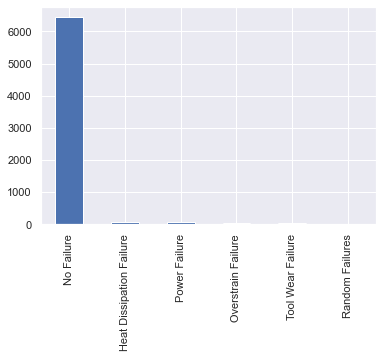

In [8]:
df['failure_type'].value_counts().plot(kind = 'bar');

**Tool Wear Failure (TWF)** - falha de desgaste da ferramenta.  
**Heat Dissipation Failure (HDF)**- falha de dissipação de calor.  
**Power Failure (PWF)** - falha de potência.  
**Overtrain Failure (OSF)** - falha por sobrecarga.  
**Random Failure (RNF)** - falha aleatória.

O variavel target apresenta 6 classes, e há um desbalanceamento pela maioria das máquinas não apresentar falhas. Podemos entender como algo natural este desbalanceamento, pois a empresa trabalha para que não haja falhas, quando ocorre é algo fora da curva, assim como se pensa em relação a fraudes, quando se pretende prever que algo está fora do padrão. 
Vamos examinar as variáveis independentes, e suas influencias nas falhas.

#### *udi*

In [9]:
df['udi'].head()

0    1
1    2
2    5
3    6
4    7
Name: udi, dtype: int64

Variável de identificação das máquinas, não será utilizada na análise e no modelo.

#### *product_id*
Código com uma letra L (low - baixa), M (medium - média) ou H (high - alta) que representa a qualidade da máquina e  um número de série.

In [10]:
df['product_id'].head()

0    M14860
1    L47181
2    L47184
3    M14865
4    L47186
Name: product_id, dtype: object

In [11]:
df['product_id'].nunique()

6667

Como o número de série é único de cada máquina, e há uma variavel que já possui qualidade separada (type), vamos desconsiderar esta variável também.

#### *type*
Qualidade da máquina low, medium ou high.

In [12]:
df['type'].describe()

count     6667
unique       3
top          L
freq      4022
Name: type, dtype: object

In [13]:
df['type'].value_counts()

L    4022
M    1987
H     658
Name: type, dtype: int64

In [14]:
df.groupby('type')['failure_type'].value_counts()

type  failure_type            
H     No Failure                   641
      Heat Dissipation Failure       7
      Power Failure                  4
      Random Failures                4
      Overstrain Failure             1
      Tool Wear Failure              1
L     No Failure                  3861
      Overstrain Failure            50
      Heat Dissipation Failure      46
      Power Failure                 39
      Tool Wear Failure             19
      Random Failures                7
M     No Failure                  1933
      Heat Dissipation Failure      22
      Power Failure                 20
      Tool Wear Failure             10
      Overstrain Failure             1
      Random Failures                1
Name: failure_type, dtype: int64

Há mais máquinas Low, então esta tende a ter mais frequências nas classes de falhas. Vamos realizar um teste de qui-quadrado (teste estatístico que, neste caso, verifica se duas variáveis categóricas - aqui failure type e type - tem associação entre si) para verificar se a qualidade influencia na falha.

In [15]:
type_quali = pd.DataFrame(df[['type','failure_type' ]].value_counts().reset_index(name = 'quant'))

In [16]:
type_quali = pd.pivot_table(type_quali, index = 'type', columns = 'failure_type',values = 'quant' )

In [17]:
type_quali

failure_type,Heat Dissipation Failure,No Failure,Overstrain Failure,Power Failure,Random Failures,Tool Wear Failure
type,,,,,,
H,7,641,1,4,4,1
L,46,3861,50,39,7,19
M,22,1933,1,20,1,10


In [18]:
_,p,_,_, = chi2_contingency(np.array(type_quali.iloc[:]))

# utilizamos um alpha de 0,05
alpha = 0.05

# H0 : Não existe relação entre qualidade e falha
# H1 : Existe relação entre qualidade e falha

print("p value é " + str(p))
if p <= alpha:
    print('Rejeitamos H0')
else:
    print('Não rejeitamos H0')


p value é 2.3370152475167822e-05
Rejeitamos H0


Assim, podemos identificar que a qualidade impacta na falha da máquina. Podemos verificar o percentual de falha (sem considerar o tipo) de acordo com a qualidade

In [19]:
low = df['type'].value_counts()[0]
medium = df['type'].value_counts()[1]
high = df['type'].value_counts()[2]

# separando as falhas sem considerar o tipo por qualidade
low_noFailure = df.loc[(df['type'] == 'L') & (df['failure_type'] != 'No Failure'), 'type'].count()
medium_noFailure = df.loc[(df['type'] == 'M') & (df['failure_type'] != 'No Failure'), 'type'].count()
high_noFailure = df.loc[(df['type'] == 'H') & (df['failure_type'] != 'No Failure'), 'type'].count()

In [20]:
print('Percentual de falhas:','\nLow:', round(low_noFailure/low * 100, 2), '%',
     '\nMedium:', round(medium_noFailure/medium * 100, 2),'%',
     '\nHigh:', round(high_noFailure/high * 100, 2),'%')

Percentual de falhas: 
Low: 4.0 % 
Medium: 2.72 % 
High: 2.58 %


As máquinas de qualidade baixa apresenta mais de 1% a mais de falhas, é um percentual pequeno mas em eventos incomuns, que é o caso das falhas, este valor é relevante. Estas máquinas deve ser mais baratas que as outras, considerando pela qualidade, e algo interessante sobre isto, é que as de qualidade média apresenta um percentual de falha próximo das de alta qualidade, podendo-se concluir, até então, que estas apresentam um melhor custo benefício. Claro, sem se considerar os custos de cada tipo de falha e suas manutenções.

#### *air_temperature_k*
Temperatura do ar em K (Kelvin). Segundo a descrição a variável está normalizada com desvio padrão de 2 e média de em torno de 300k.

In [21]:
df['air_temperature_k'].describe()

count    6667.000000
mean      299.992515
std         1.994710
min       295.300000
25%       298.300000
50%       300.000000
75%       301.500000
max       304.500000
Name: air_temperature_k, dtype: float64

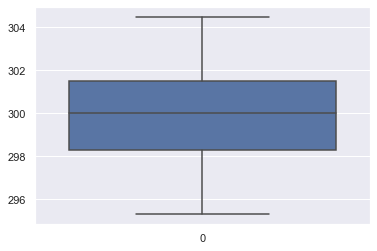

In [22]:
sns.boxplot(df['air_temperature_k']);

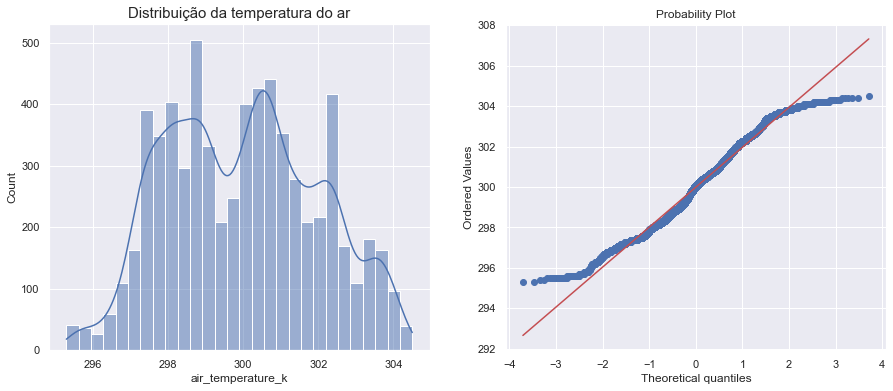

In [23]:
# analisando a distribuição dos dados pelo histograma e se aproxima-se de uma distribuição normal
plt.subplots(figsize=(15,6))

plt.subplot(121)
plt.title('Distribuição da temperatura do ar', fontsize = 15)
sns.histplot(df['air_temperature_k'], kde = True)

plt.subplot(122)
stats.probplot(df['air_temperature_k'], plot = plt);

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data = df, x = 'failure_type', y = 'air_temperature_k');
plt.title('Temperatura do ar x Tipos de falhas', fontsize = 15)
plt.setp(ax.get_xticklabels(), rotation=90);


Média No Failure: 299.96 |Mediana No Failure: 300.0


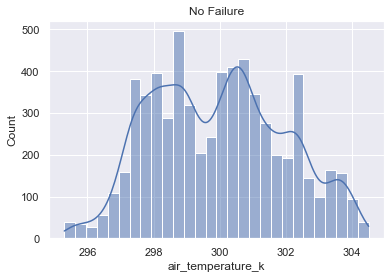

------------------------------------------------------
Média Power Failure: 299.89 |Mediana Power Failure: 299.9


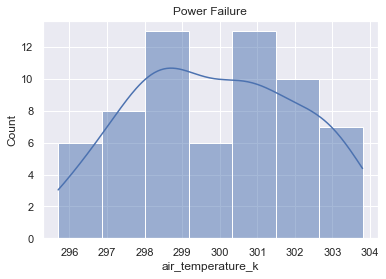

------------------------------------------------------
Média Tool Wear Failure: 300.2 |Mediana Tool Wear Failure: 300.4


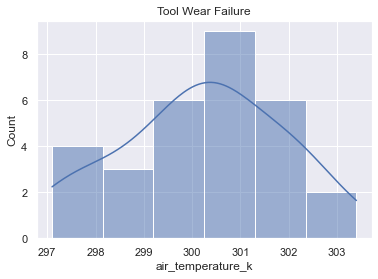

------------------------------------------------------
Média Overstrain Failure: 299.96 |Mediana Overstrain Failure: 299.45


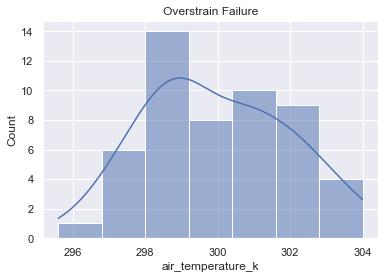

------------------------------------------------------
Média Random Failures: 300.69 |Mediana Random Failures: 300.65


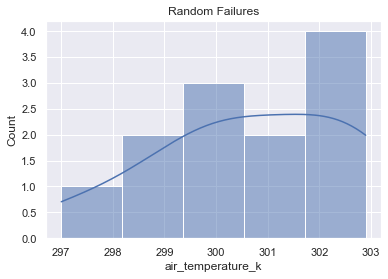

------------------------------------------------------
Média Heat Dissipation Failure: 302.55 |Mediana Heat Dissipation Failure: 302.5


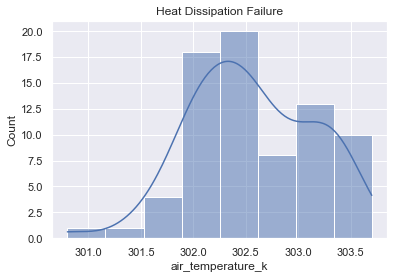

------------------------------------------------------


In [24]:
# visualização pelo histograma de air temperature por tipo de falha
qualities = df['failure_type'].unique()

for i in qualities:
    
    data = df.loc[df['failure_type'] == i, 'air_temperature_k']
    print(f'Média {i}:', round(data.mean(),2), f'|Mediana {i}:', round(data.median(),2))
    plt.title(i)
    
    sns.histplot(data, kde = True)
    
    plt.show()
    print('------------------------------------------------------')
   

Esta variável não apresenta uma distribuição próxima de normal, há muitos picos de valores, também não há outliers, e isto acontece mesmo se separando por tipos de falhas. Todos os tipos de falhas possuem médias próximas (cerca de 300k), apenas a categoria Heat Dissipation Failure sai do padrão e acontece mais em temperaturas de ar altas acima do desvio padrão (1,99), mas deve-se atentar que todas as outras também apresentam máquinas com temperaturas altas. A melhor informação desta variável encontrada é que, nos valores bem extremos não se encontra falha.

#### *process_temperature_k*
Temperatura do processo, também normalizada com desvio padrão de 1 k, é adicionado 10 k a mais que a temperatura do ar.

In [25]:
df['process_temperature_k'].describe()

count    6667.000000
mean      309.992620
std         1.488101
min       305.700000
25%       308.800000
50%       310.000000
75%       311.100000
max       313.800000
Name: process_temperature_k, dtype: float64

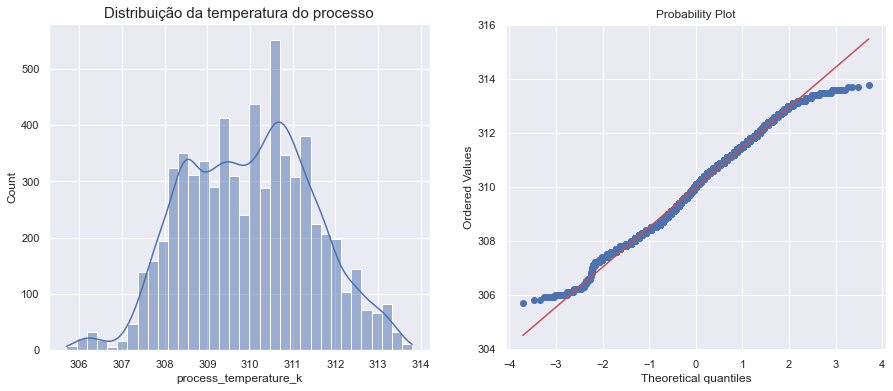

In [26]:
plt.subplots(figsize=(15,6))

plt.subplot(121)
plt.title('Distribuição da temperatura do processo', fontsize = 15)
sns.histplot(df['process_temperature_k'], kde = True)

plt.subplot(122)
stats.probplot(df['process_temperature_k'], plot = plt);

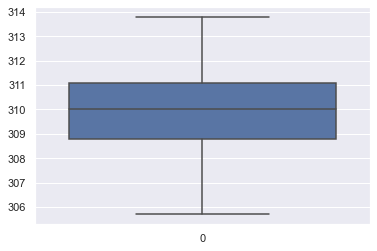

In [27]:
sns.boxplot(df['process_temperature_k']);

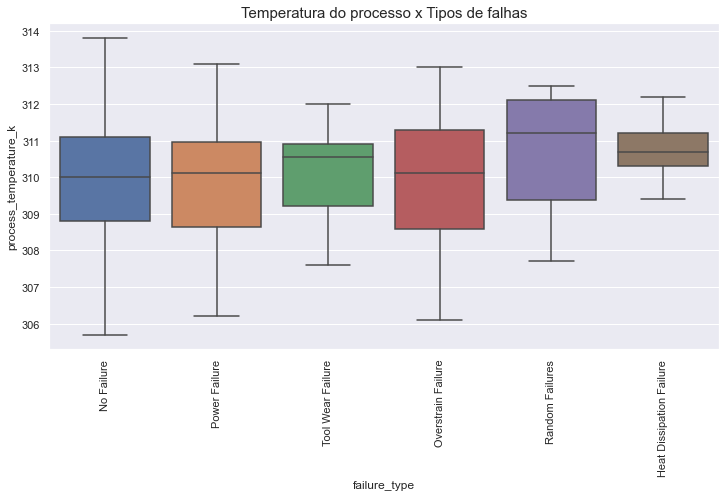

In [28]:
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data = df, x = 'failure_type', y = 'process_temperature_k');
plt.title('Temperatura do processo x Tipos de falhas', fontsize = 15)
plt.setp(ax.get_xticklabels(), rotation=90);

A maioria das categorias estão com seus valores mais frequentes entre 309 e 311, somente Random Failures tem praticamente metade de suas máquinas acima disto. Tool Wear Failure e Heat Dissipation Failure não atingem os valores mais altos.

#### *rotational_speed_rpm*
Velocidade de rotação em rpm

In [29]:
df['rotational_speed_rpm'].head()

0    1551
1    1408
2    1408
3    1425
4    1558
Name: rotational_speed_rpm, dtype: int64

In [30]:
df['rotational_speed_rpm'].describe()

count    6667.000000
mean     1537.419529
std       177.182908
min      1168.000000
25%      1422.500000
50%      1503.000000
75%      1612.000000
max      2886.000000
Name: rotational_speed_rpm, dtype: float64

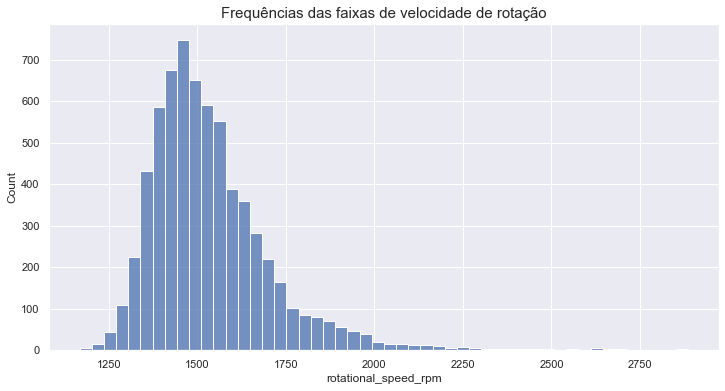

In [31]:
plt.figure(figsize=(12, 6))
plt.title('Frequências das faixas de velocidade de rotação', fontsize = 15)
sns.histplot(df['rotational_speed_rpm'], bins = 50);

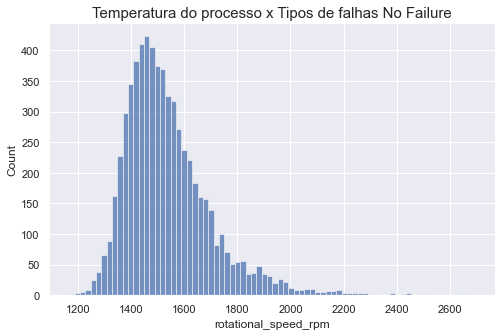

---------------------------------------------------------------------


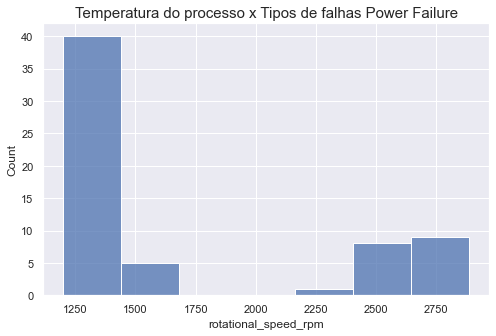

---------------------------------------------------------------------


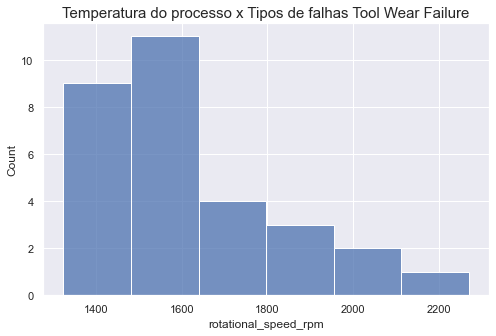

---------------------------------------------------------------------


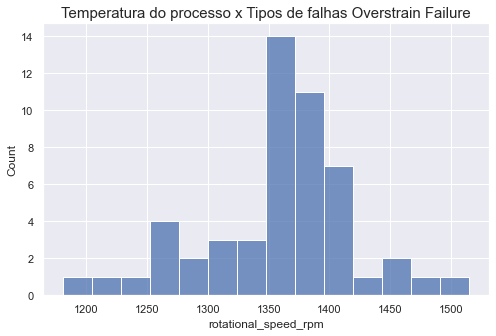

---------------------------------------------------------------------


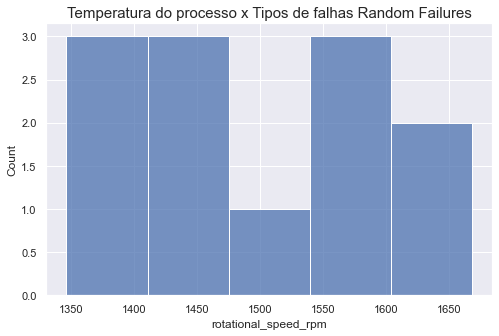

---------------------------------------------------------------------


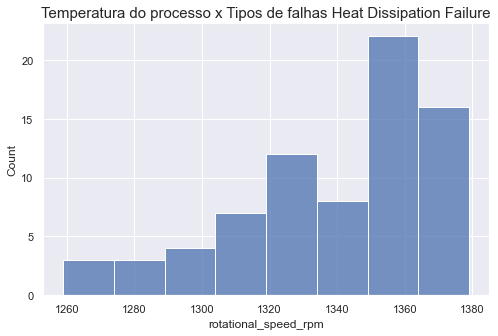

---------------------------------------------------------------------


In [32]:

for i in qualities:
    
    data = df.loc[df['failure_type'] == i, 'rotational_speed_rpm']
    plt.figure(figsize=(8, 5))
    plt.title(f'Temperatura do processo x Tipos de falhas {i}', fontsize = 15);
    sns.histplot(data);
    plt.show()
    print('---------------------------------------------------------------------')
   

Não ocorrem falhas de Power Failure em torno de 1700 e 2200, valores de 1250, são mais prováveis falhas desta categoria. Falhas de Overstrain ocorrem mais nas faixas de 1350 e 1400 e esta falha não ocorre em rotações mais altas acima de 1600. Pelas visualições se entende que é melhor mantes as rotações próximo da média (1500 rpm) as falhas tendem para os extremos, principalmente baixas rotações.

#### *torque_nm*
Torque, valor em Newton metro. Normalizado com média de 40 nm e desvio padrao de 10 nm, sem valores negativos.

In [33]:
df['torque_nm'].head()

0    42.8
1    46.3
2    40.0
3    41.9
4    42.4
Name: torque_nm, dtype: float64

In [34]:
df['torque_nm'].describe()

count    6667.000000
mean       40.058512
std         9.950804
min         3.800000
25%        33.200000
50%        40.200000
75%        46.800000
max        76.600000
Name: torque_nm, dtype: float64

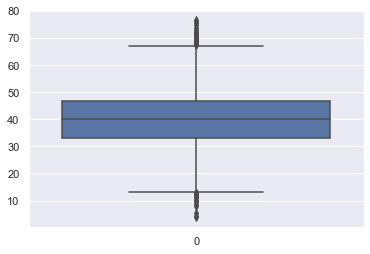

In [35]:
sns.boxplot(df['torque_nm']);

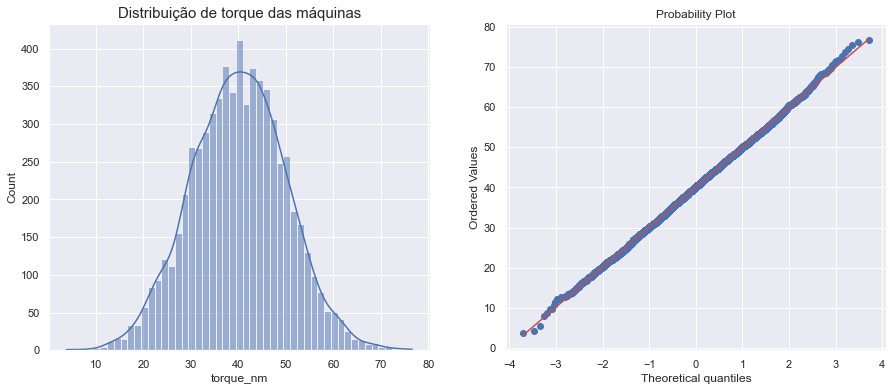

In [36]:
plt.subplots(figsize=(15,6))

plt.subplot(121)
plt.title('Distribuição de torque das máquinas', fontsize = 15)
sns.histplot(df['torque_nm'], kde = True)

plt.subplot(122)
stats.probplot(df['torque_nm'], plot = plt);

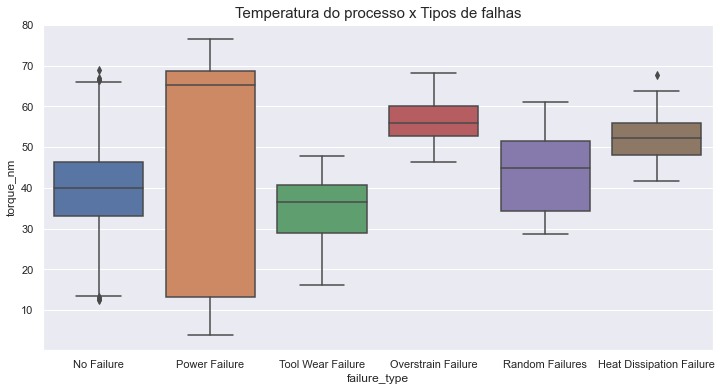

In [37]:
plt.figure(figsize=(12, 6))
sns.boxplot(data = df, x = 'failure_type', y = 'torque_nm');
plt.title('Temperatura do processo x Tipos de falhas', fontsize = 15)
plt.setp(ax.get_xticklabels(), rotation=90);

Variável com distribuição normal e possui alguns outliers. A certeza de falha ocorre em valores bem extremos e serão de Power Failure.

#### *tool_wear_min*
Desgaste da ferramenta em minutos.As variantes de qualidade H/M/L adicionam 5/3/2 minutos de desgaste à ferramenta utilizada no processo.

In [38]:
df['tool_wear_min'].head()

0     0
1     3
2     9
3    11
4    14
Name: tool_wear_min, dtype: int64

In [39]:
df['tool_wear_min'].describe()

count    6667.000000
mean      108.098095
std        63.359915
min         0.000000
25%        54.000000
50%       108.000000
75%       162.000000
max       251.000000
Name: tool_wear_min, dtype: float64

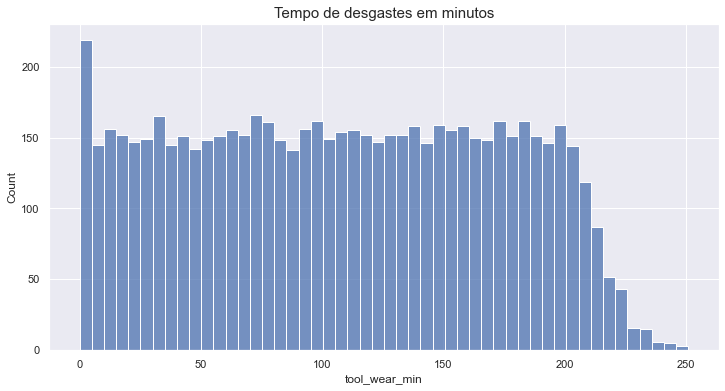

In [40]:
plt.figure(figsize=(12, 6))
plt.title('Tempo de desgastes em minutos', fontsize = 15)
sns.histplot(df['tool_wear_min'], bins = 50);

A não ser pelos extremos, esta variável segue uma distribuição uniforme

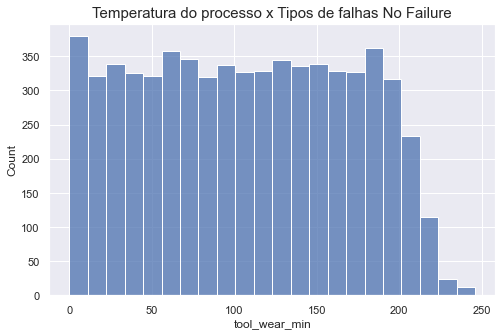

---------------------------------------------------------------------


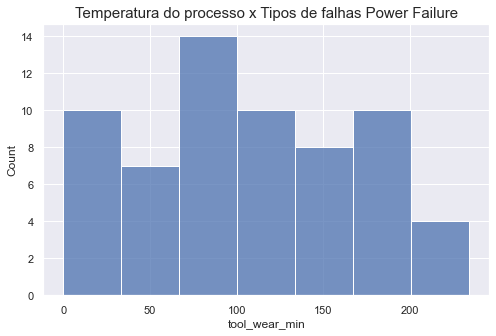

---------------------------------------------------------------------


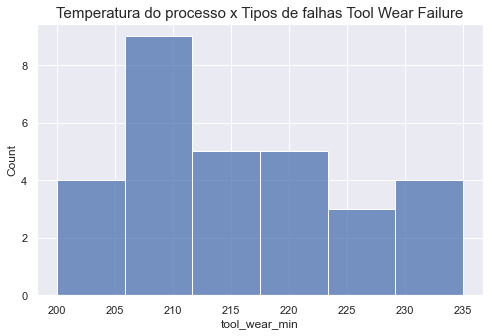

---------------------------------------------------------------------


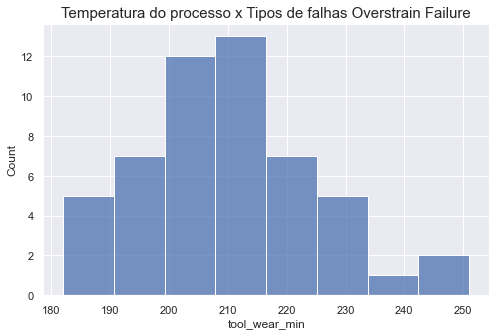

---------------------------------------------------------------------


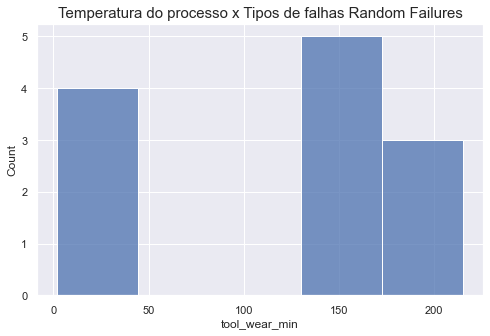

---------------------------------------------------------------------


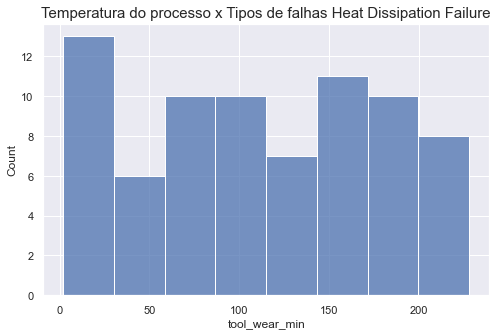

---------------------------------------------------------------------


In [41]:
for i in qualities:
    
    data = df.loc[df['failure_type'] == i, 'tool_wear_min']
    plt.figure(figsize=(8, 5))
    plt.title(f'Temperatura do processo x Tipos de falhas {i}', fontsize = 15);
    sns.histplot(data);
    plt.show()
    print('---------------------------------------------------------------------')
   

Esta variável tem maior impacto nas falhas em valores altos, as falhas ocorrem mais em torno de 200 para mais de torque.

## Análise multivariada

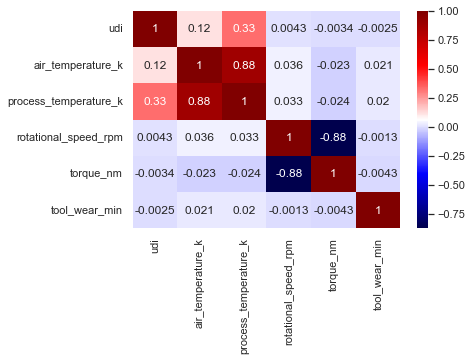

In [72]:
sns.heatmap(df.corr(), annot = True, cmap='seismic');

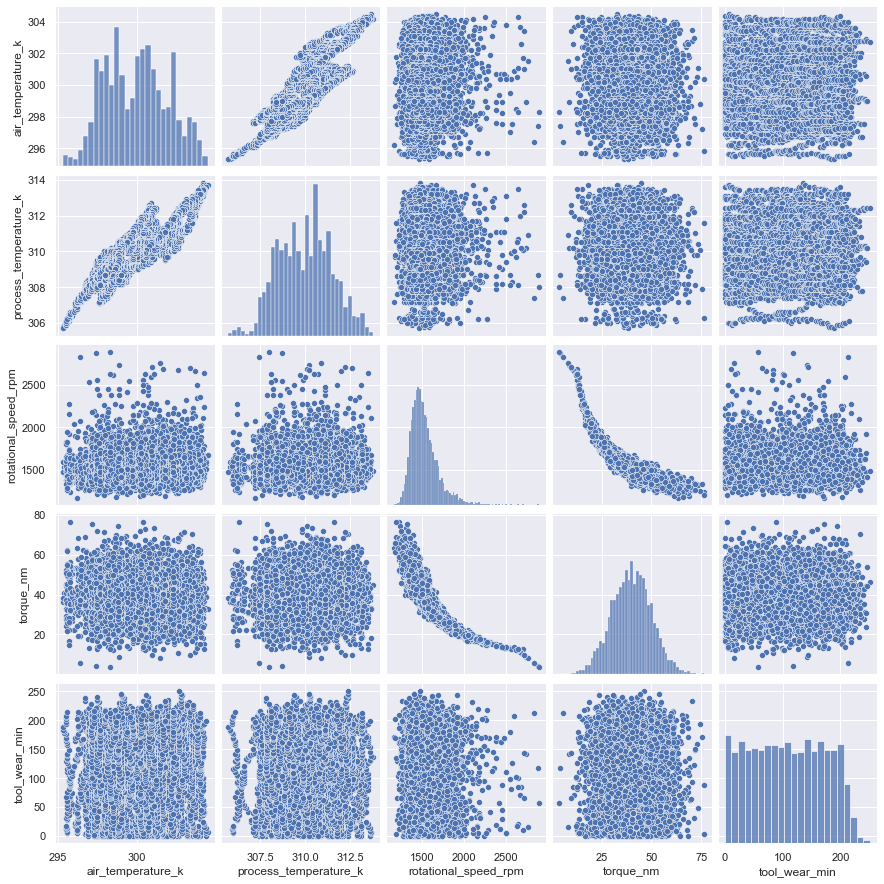

In [42]:
sns.pairplot(df.drop(['udi', 'product_id'], axis = 1))

Nestes gráficos podemos verificar algumas relações: air_temperature_k  e process_temperature_k tem relação linear positiva como se imaginava, rotational_speed_rpm e torque_nm algo exponencial e decrescente. Vamos analisá-las junto da variável alvo.

#### *air_temperature_k X process_temperature_k e tipos de falhas*

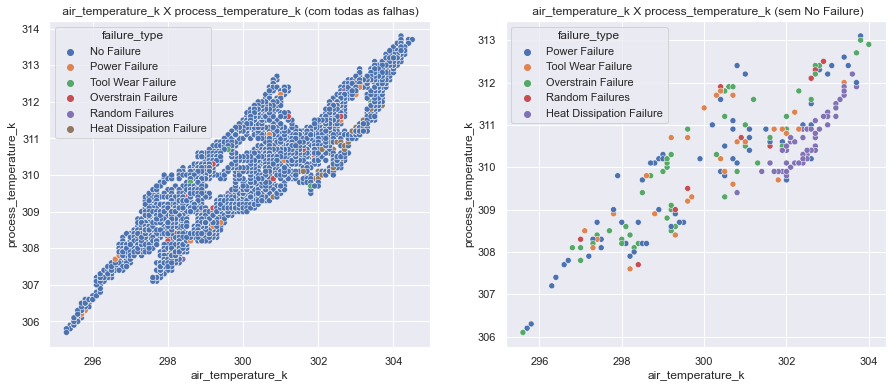

In [43]:
plt.subplots(figsize=(15,6))

plt.subplot(121)
plt.title(" air_temperature_k X process_temperature_k (com todas as falhas)")
sns.scatterplot(data = df, x = 'air_temperature_k', y = 'process_temperature_k', hue = 'failure_type');

plt.subplot(122)
plt.title(" air_temperature_k X process_temperature_k (sem No Failure)")
data = df.loc[df['failure_type'] != 'No Failure']
sns.scatterplot(data = data, x = 'air_temperature_k', y = 'process_temperature_k', hue = 'failure_type');

Este gráfico é interessante para mostrar que as falhas de Heat Dissipation ocorrem na faixa de 302k a 304k de air temperature e 310k a 312k de process temperature.

#### *rotational_speed_rpm X torque_nm*

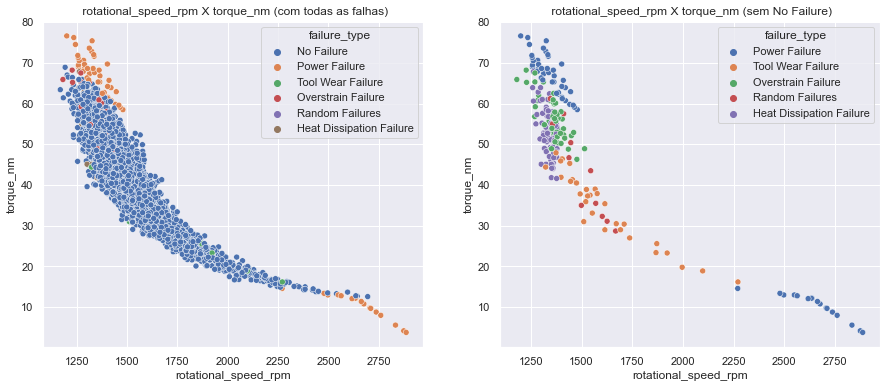

In [44]:
plt.subplots(figsize=(15,6))

plt.subplot(121)
plt.title(" rotational_speed_rpm X torque_nm (com todas as falhas)")
sns.scatterplot(data = df, x = 'rotational_speed_rpm', y = 'torque_nm', hue = 'failure_type');

plt.subplot(122)
plt.title(" rotational_speed_rpm X torque_nm (sem No Failure)")
data = df.loc[df['failure_type'] != 'No Failure']
sns.scatterplot(data = data, x = 'rotational_speed_rpm', y = 'torque_nm', hue = 'failure_type');


Pode-se notar visualmente um pouco de distinção nos grupos, nos extremos(acima e abaixo) aparece somente a classe Power Failure, talvez, a informação mais importante e relevante encontrada.

#### *air_temperature_k X rotational_speed_rpm*

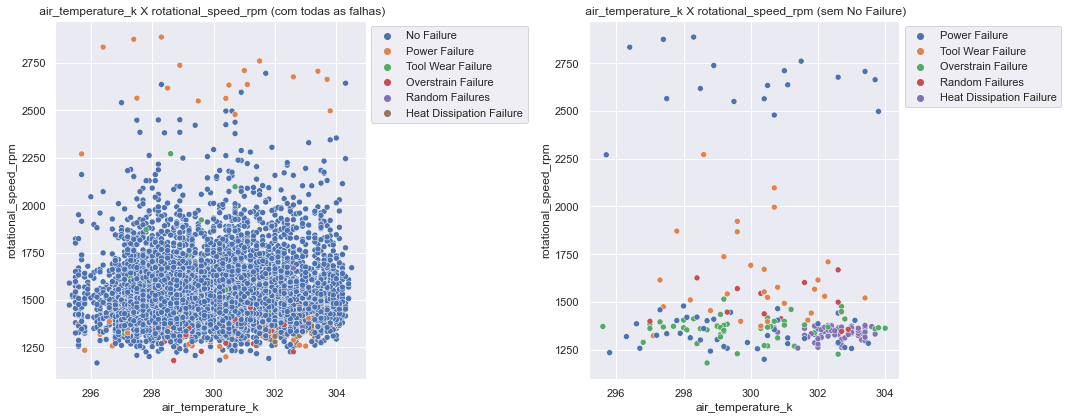

In [57]:
plt.subplots(figsize=(15,6))

plt.subplot(121)
plt.title(" air_temperature_k X rotational_speed_rpm (com todas as falhas)")
sns.scatterplot(data = df, x = 'air_temperature_k', y = 'rotational_speed_rpm', hue = 'failure_type');
plt.legend(bbox_to_anchor = (1,1))

plt.subplot(122)
plt.title(" air_temperature_k X rotational_speed_rpm (sem No Failure)")
data = df.loc[df['failure_type'] != 'No Failure']
sns.scatterplot(data = data, x = 'air_temperature_k', y = 'rotational_speed_rpm', hue = 'failure_type');
plt.legend(bbox_to_anchor = (1,1))
plt.tight_layout();

Nesta visualização percebemos que a boa parte das falhas acontecem nos menores valores de rotational speed. Power Failure sempre nos extremos,podemos agrupar as falhas de Heat Dissipation nos valores maiores de temperatura de ar e baixas rotações. Falhas Overstrain em baixas rotações mas, em qualquer faixa de temperatura do ar.

## Conclusão EDA

Rotational speed e torque são as variáveis das mais importantes para se encontrar falhas, essencialmente Power Failure. Altas temperaturas (ar ou processo) não implicam necessariamente em falhas. Air temperature não parecer ter muita influencia para encontrar se há falhas, mas pode contribuir, para quando se encontra falhas, prever o tipo, pois em valores extremos não há falhas Tool Wear e Random. O uso de árvores de decisão neste problema pode contribuir muito, pois pode encontrar faixas de cortes importantes para alcançar o padrão de falhas e seus tipos.

### Feature Engineering

Precisamos transformar a variável type para numérica, a princípio sabemos que há uma diferença de qualidade entre high, medium e low, mas, não sabemos a proporção, assim, será utilizado dummy para binarizar esta variável. Vamos tratar de prever, inicialmente, se há falhas ou não, assim, é necessário criar uma outra variável binária, onde, 0 para sem falha e 1 para falha. Será transformada a variavel Failure Type com o Label Encoder para uso nos modelos, alterando os tipos de erro para numérico.

#### *type*

Para a variável type será criada duas colunas representando a categoria da qualidade, o valor 1 será atribuida a coluna da respectiva qualidade da máquina, para indicar a terceira categoria da qualidade as 2 colunas ficam com o valor 0. Isto evita o problema de multicolinearidade, onde a variáveis tem correlação muito forte entre si, sendo um problema para o desempenho de alguns modelos.

In [12]:
# instanciando a função que cria as variaveis binarias, com 'drop' removendo a primeira categoria
enc = OneHotEncoder(handle_unknown='ignore', drop = 'first')

# fitando e transformando a variável type
type_transform = enc.fit_transform(df['type'].values.reshape(-1,1)).toarray()

# criando um dataframe com as novas colunas e concatenando com o base principal
df_type = pd.DataFrame(type_transform, columns = ['Type 0', 'Type 1'])
df = pd.concat([df,df_type], axis = 1)
df.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,Type 0,Type 1
0,1,M14860,M,298.1,308.6,1551,42.8,0,No Failure,0.0,1.0
1,2,L47181,L,298.2,308.7,1408,46.3,3,No Failure,1.0,0.0
2,5,L47184,L,298.2,308.7,1408,40.0,9,No Failure,1.0,0.0
3,6,M14865,M,298.1,308.6,1425,41.9,11,No Failure,0.0,1.0
4,7,L47186,L,298.1,308.6,1558,42.4,14,No Failure,1.0,0.0


In [13]:
# variavel binaria, 0 sem falha e 1 com falha
df['failure'] = list(map(lambda x: 0 if x == 'No Failure' else 1, df['failure_type']))
df['failure'].head()

0    0
1    0
2    0
3    0
4    0
Name: failure, dtype: int64

In [14]:
# criando labels para variavel alvo failure type
le = LabelEncoder()
df['failure_type_label'] = le.fit_transform(df['failure_type'])
df['failure_type_label'].unique()

array([1, 3, 5, 2, 4, 0])

In [15]:
le.classes_

array(['Heat Dissipation Failure', 'No Failure', 'Overstrain Failure',
       'Power Failure', 'Random Failures', 'Tool Wear Failure'],
      dtype=object)

In [16]:
# gerando arquivo pickle do encoder para utiliza-lo em uma função
pickle.dump(le, open('label_failure.pkl', 'wb'))


### Balanceamento dos dados

A base de dados é muito enviesada pela classe 'sem falhas' (No Failure), prejudicando o desempenho de modelos para prever falhas e seus tipos. Será utilizado, então,a técnica de rebalancamento oversampling, com o algoritmo SMOTE.

In [17]:
X = df.drop(['udi','product_id', 'failure_type', 'failure', 'type', 'failure_type_label'], axis = 1)
y = df['failure']
X.shape, y.shape

((6667, 7), (6667,))

In [18]:
smote = SMOTE()

X_smote, y_smote = smote.fit_resample(X, y)

y_smote.value_counts()

0    6435
1    6435
Name: failure, dtype: int64

### Modelos de machine learning

Este problema é de classificação onde se deseja encontrar a qual categoria a amostra pertence. A partir dos dados transformados vamos analisar as performances de modelos baseados em algorimtos de árvores de decisão, pois não é necessário normalização ou padronização dos dados, e SVM (somente testar no modelo 2 - classificar o tipo de falha- pois a base de dados é menor, e este algoritmo leva um tempo maior para realizar o treinamento)

In [19]:
# separando dados de treino e validaçãp
X_train, X_valid, y_train, y_valid = train_test_split(X_smote, 
                                                    y_smote, 
                                                     test_size = 0.3,
                                                    random_state=30)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(9009, 7) (9009,)
(3861, 7) (3861,)


### Modelo1 -  detecção de falhas

Neste primeiro modelo vamos utilizar a variável 'failure' como o target ( 0 sem falha, 1 com falha), sem considerar o tipo de falha. Isto visa criar um modelo que aprenda somente o que é falha e o que não é e retornando esta predição, para que outro modelo aprenda a diferenciar os tipos de falha somente com uma base de dados que tenham falhas. A métrica de ênfase é a 'recall', que considera a quantidade de acertos dos positivos (falhas) pelo total de positivos da base de dados, ou seja, da quantidade de falhas que há quantas o modelo consegue detectar. 

#### Modelo Random Forest

Escolhido este algoritmo primeiro, pois tem explicabilidade mais simples, poucos hiperparâmetros, e também retornar a importância de cada variavel, mas a performance pode nçao ser tão boa.

In [403]:
modelo = RandomForestClassifier()
parameters = {
    'max_depth': [ 3, 5, 10],
    'n_estimators': [100, 500,1000],
    'criterion': ['entropy', 'gini'],
    }

clf_rf = GridSearchCV(modelo, parameters, verbose=3, scoring='recall', cv= 3)

clf_rf.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END criterion=entropy, max_depth=3, n_estimators=100;, score=0.923 total time=   0.3s
[CV 2/3] END criterion=entropy, max_depth=3, n_estimators=100;, score=0.926 total time=   0.3s
[CV 3/3] END criterion=entropy, max_depth=3, n_estimators=100;, score=0.925 total time=   0.3s
[CV 1/3] END criterion=entropy, max_depth=3, n_estimators=500;, score=0.929 total time=   1.7s
[CV 2/3] END criterion=entropy, max_depth=3, n_estimators=500;, score=0.922 total time=   1.7s
[CV 3/3] END criterion=entropy, max_depth=3, n_estimators=500;, score=0.930 total time=   1.7s
[CV 1/3] END criterion=entropy, max_depth=3, n_estimators=1000;, score=0.933 total time=   3.5s
[CV 2/3] END criterion=entropy, max_depth=3, n_estimators=1000;, score=0.926 total time=   3.7s
[CV 3/3] END criterion=entropy, max_depth=3, n_estimators=1000;, score=0.928 total time=   3.5s
[CV 1/3] END criterion=entropy, max_depth=5, n_estimators=100;, score=0.961 total

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [100, 500, 1000]},
             scoring='recall', verbose=3)

In [404]:
clf_rf.best_params_

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 500}

In [405]:
clf_rf = RandomForestClassifier(random_state = 30, max_depth = 10, criterion = 'gini', n_estimators = 500)

clf_rf.fit(X_train, y_train)
y_train_pred = clf_rf.predict(X_train)
y_valid_pred = clf_rf.predict(X_valid)

print_metrics('Treino',y_train,y_train_pred, 'Validação',y_valid, y_valid_pred)

Treino:
Acc: 0.9818, Precision: 0.9751, Recall: 0.9886
Validação:
Acc: 0.9635, Precision: 0.9574, Recall: 0.9715


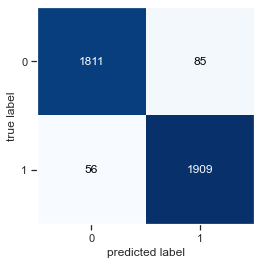

In [406]:
plot_confusion_matrix(confusion_matrix(y_valid, y_valid_pred));

O modelo performou bem. Este aprendeu bem a classe de falhas (1), errou menos falsos postivos do que falso negativos

In [407]:
# verificando a impacto das variáveis no modelo
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': clf_rf.feature_importances_,
    }).sort_values('importance', ascending=False)

importances

,feature,importance
3,torque_nm,0.270255
2,rotational_speed_rpm,0.265655
4,tool_wear_min,0.190535
5,Type 0,0.094530
0,air_temperature_k,0.073403
6,Type 1,0.063418
1,process_temperature_k,0.042205


No modelo com random forest as variáveis rotational speed e torque são as mais importantes, nas análises anteriores vimos que valores extremos destas duas geram falhas na categoria Power Failure.

#### Modelo LGBM

Este algoritmo tem tendência para o overfitting, mas, se trabalhando os hiperparâmetros, pode-se alcançar boa métricas além de realizar um treinamento mais rápido.

In [408]:
model = LGBMClassifier()

parameters = {
    'max_depth': [ 3, 5, 10],
    'n_estimators': [50, 100, 500],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'is_unbalance': [True, False],
    'importance_type':['gain', 'split']
    }

clf_lgbm = GridSearchCV(model, parameters, verbose=3, scoring='recall', cv= 3)

clf_lgbm.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV 1/3] END importance_type=gain, is_unbalance=True, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.912 total time=   0.0s
[CV 2/3] END importance_type=gain, is_unbalance=True, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.921 total time=   0.0s
[CV 3/3] END importance_type=gain, is_unbalance=True, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.926 total time=   0.0s
[CV 1/3] END importance_type=gain, is_unbalance=True, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.939 total time=   0.0s
[CV 2/3] END importance_type=gain, is_unbalance=True, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.941 total time=   0.0s
[CV 3/3] END importance_type=gain, is_unbalance=True, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.952 total time=   0.0s
[CV 1/3] END importance_type=gain, is_unbalance=True, learning_rate=0.01, max_depth=3, n_estimators=500;, score=0.954 

[CV 2/3] END importance_type=gain, is_unbalance=True, learning_rate=0.5, max_depth=3, n_estimators=500;, score=0.991 total time=   0.1s
[CV 3/3] END importance_type=gain, is_unbalance=True, learning_rate=0.5, max_depth=3, n_estimators=500;, score=0.984 total time=   0.1s
[CV 1/3] END importance_type=gain, is_unbalance=True, learning_rate=0.5, max_depth=5, n_estimators=50;, score=0.982 total time=   0.0s
[CV 2/3] END importance_type=gain, is_unbalance=True, learning_rate=0.5, max_depth=5, n_estimators=50;, score=0.986 total time=   0.0s
[CV 3/3] END importance_type=gain, is_unbalance=True, learning_rate=0.5, max_depth=5, n_estimators=50;, score=0.979 total time=   0.0s
[CV 1/3] END importance_type=gain, is_unbalance=True, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.985 total time=   0.0s
[CV 2/3] END importance_type=gain, is_unbalance=True, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.988 total time=   0.0s
[CV 3/3] END importance_type=gain, is_unbalance=Tru

[CV 3/3] END importance_type=gain, is_unbalance=False, learning_rate=0.01, max_depth=5, n_estimators=100;, score=0.955 total time=   0.0s
[CV 1/3] END importance_type=gain, is_unbalance=False, learning_rate=0.01, max_depth=5, n_estimators=500;, score=0.977 total time=   0.2s
[CV 2/3] END importance_type=gain, is_unbalance=False, learning_rate=0.01, max_depth=5, n_estimators=500;, score=0.968 total time=   0.3s
[CV 3/3] END importance_type=gain, is_unbalance=False, learning_rate=0.01, max_depth=5, n_estimators=500;, score=0.972 total time=   0.2s
[CV 1/3] END importance_type=gain, is_unbalance=False, learning_rate=0.01, max_depth=10, n_estimators=50;, score=0.952 total time=   0.0s
[CV 2/3] END importance_type=gain, is_unbalance=False, learning_rate=0.01, max_depth=10, n_estimators=50;, score=0.944 total time=   0.0s
[CV 3/3] END importance_type=gain, is_unbalance=False, learning_rate=0.01, max_depth=10, n_estimators=50;, score=0.964 total time=   0.0s
[CV 1/3] END importance_type=gain,

[CV 1/3] END importance_type=gain, is_unbalance=False, learning_rate=0.5, max_depth=10, n_estimators=100;, score=0.991 total time=   0.0s
[CV 2/3] END importance_type=gain, is_unbalance=False, learning_rate=0.5, max_depth=10, n_estimators=100;, score=0.990 total time=   0.0s
[CV 3/3] END importance_type=gain, is_unbalance=False, learning_rate=0.5, max_depth=10, n_estimators=100;, score=0.986 total time=   0.0s
[CV 1/3] END importance_type=gain, is_unbalance=False, learning_rate=0.5, max_depth=10, n_estimators=500;, score=0.991 total time=   0.1s
[CV 2/3] END importance_type=gain, is_unbalance=False, learning_rate=0.5, max_depth=10, n_estimators=500;, score=0.991 total time=   0.1s
[CV 3/3] END importance_type=gain, is_unbalance=False, learning_rate=0.5, max_depth=10, n_estimators=500;, score=0.986 total time=   0.1s
[CV 1/3] END importance_type=gain, is_unbalance=False, learning_rate=1, max_depth=3, n_estimators=50;, score=0.981 total time=   0.0s
[CV 2/3] END importance_type=gain, is_

[CV 3/3] END importance_type=split, is_unbalance=True, learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.970 total time=   0.0s
[CV 1/3] END importance_type=split, is_unbalance=True, learning_rate=0.1, max_depth=3, n_estimators=500;, score=0.985 total time=   0.0s
[CV 2/3] END importance_type=split, is_unbalance=True, learning_rate=0.1, max_depth=3, n_estimators=500;, score=0.983 total time=   0.0s
[CV 3/3] END importance_type=split, is_unbalance=True, learning_rate=0.1, max_depth=3, n_estimators=500;, score=0.975 total time=   0.0s
[CV 1/3] END importance_type=split, is_unbalance=True, learning_rate=0.1, max_depth=5, n_estimators=50;, score=0.977 total time=   0.0s
[CV 2/3] END importance_type=split, is_unbalance=True, learning_rate=0.1, max_depth=5, n_estimators=50;, score=0.968 total time=   0.0s
[CV 3/3] END importance_type=split, is_unbalance=True, learning_rate=0.1, max_depth=5, n_estimators=50;, score=0.970 total time=   0.0s
[CV 1/3] END importance_type=split, is_unbal

[CV 3/3] END importance_type=split, is_unbalance=True, learning_rate=1, max_depth=5, n_estimators=100;, score=0.685 total time=   0.0s
[CV 1/3] END importance_type=split, is_unbalance=True, learning_rate=1, max_depth=5, n_estimators=500;, score=0.988 total time=   0.1s
[CV 2/3] END importance_type=split, is_unbalance=True, learning_rate=1, max_depth=5, n_estimators=500;, score=0.988 total time=   0.1s
[CV 3/3] END importance_type=split, is_unbalance=True, learning_rate=1, max_depth=5, n_estimators=500;, score=0.685 total time=   0.0s
[CV 1/3] END importance_type=split, is_unbalance=True, learning_rate=1, max_depth=10, n_estimators=50;, score=0.838 total time=   0.0s
[CV 2/3] END importance_type=split, is_unbalance=True, learning_rate=1, max_depth=10, n_estimators=50;, score=0.985 total time=   0.0s
[CV 3/3] END importance_type=split, is_unbalance=True, learning_rate=1, max_depth=10, n_estimators=50;, score=0.739 total time=   0.0s
[CV 1/3] END importance_type=split, is_unbalance=True, 

[CV 1/3] END importance_type=split, is_unbalance=False, learning_rate=0.1, max_depth=10, n_estimators=100;, score=0.984 total time=   0.0s
[CV 2/3] END importance_type=split, is_unbalance=False, learning_rate=0.1, max_depth=10, n_estimators=100;, score=0.984 total time=   0.0s
[CV 3/3] END importance_type=split, is_unbalance=False, learning_rate=0.1, max_depth=10, n_estimators=100;, score=0.981 total time=   0.0s
[CV 1/3] END importance_type=split, is_unbalance=False, learning_rate=0.1, max_depth=10, n_estimators=500;, score=0.989 total time=   0.3s
[CV 2/3] END importance_type=split, is_unbalance=False, learning_rate=0.1, max_depth=10, n_estimators=500;, score=0.991 total time=   0.3s
[CV 3/3] END importance_type=split, is_unbalance=False, learning_rate=0.1, max_depth=10, n_estimators=500;, score=0.986 total time=   0.3s
[CV 1/3] END importance_type=split, is_unbalance=False, learning_rate=0.5, max_depth=3, n_estimators=50;, score=0.975 total time=   0.0s
[CV 2/3] END importance_type=

GridSearchCV(cv=3, estimator=LGBMClassifier(),
             param_grid={'importance_type': ['gain', 'split'],
                         'is_unbalance': [True, False],
                         'learning_rate': [0.01, 0.1, 0.5, 1],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [50, 100, 500]},
             scoring='recall', verbose=3)

In [409]:
clf_lgbm.best_params_

{'importance_type': 'gain',
 'is_unbalance': False,
 'learning_rate': 0.5,
 'max_depth': 10,
 'n_estimators': 500}

In [20]:
clf_lgbm = LGBMClassifier(random_state = 30, importance_type = 'gain',  learning_rate = 0.05,
                             max_depth = 5, n_estimators = 500)

clf_lgbm.fit(X_train, y_train)
y_train_pred = clf_lgbm.predict(X_train)
y_valid_pred = clf_lgbm.predict(X_valid)

print_metrics('Treino',y_train,y_train_pred, 'Validação',y_valid, y_valid_pred)

Treino:
Acc: 0.9989, Precision: 0.9996, Recall: 0.9982
Validação:
Acc: 0.9806, Precision: 0.9802, Recall: 0.9817


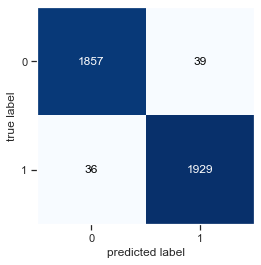

In [21]:

plot_confusion_matrix(confusion_matrix(y_valid, y_valid_pred));

Este modelo conseguiu prever bem as falhas um pouco melhor que o Random Forest. Foi alterado hiperparâmetros para não ocorrer o overfitting.

In [22]:
# arquivo pickle para armazenar o modelo LGBM
pickle.dump(clf_lgbm, open('detect_failure.pkl', 'wb'))

### Modelo2 -  detecção de tipo falha

Primeiramente, vamos separar a base de dados de treinamento somente com dados com falhas

In [23]:
df_with_failure = df.loc[df['failure_type'] != 'No Failure']
df_with_failure.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,Type 0,Type 1,failure,failure_type_label
52,70,L47249,L,298.9,309.0,1410,65.7,191,Power Failure,1.0,0.0,1,3
56,78,L47257,L,298.8,308.9,1455,41.3,208,Tool Wear Failure,1.0,0.0,1,5
112,161,L47340,L,298.4,308.2,1282,60.7,216,Overstrain Failure,1.0,0.0,1,2
113,162,L47341,L,298.3,308.1,1412,52.3,218,Overstrain Failure,1.0,0.0,1,2
143,208,M15067,M,298.4,308.7,1421,60.7,119,Power Failure,0.0,1.0,1,3


In [24]:
# variavel alvo será a failure type label, que fo transformada da failure type pela função Label Encoder
X_failure = df_with_failure.drop(['udi','product_id', 'failure_type', 'failure', 'type', 'failure_type_label'], axis = 1)
y_failure = df_with_failure['failure_type_label']
X_failure.shape, y_failure.shape

((232, 7), (232,))

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X_failure, 
                                                    y_failure, 
                                                     stratify=y_failure, shuffle=True,
                                                    random_state=30)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(174, 7) (174,)
(58, 7) (58,)


Para este modelo vamos usar a métrica F1 macro, que é uma média harmônica do precision (dos dados preditos como tal classe avalia quantos estão corretos) e recall (da quantidade de tal tipo de classe avalia quantos foram detectados) de cada classe  (tipo de falha).

#### Modelo tipo de falha - Random Forest

In [368]:
modelo = RandomForestClassifier()
parameters = {
    'max_depth': [ 3, 5, 10],
    'n_estimators': [100, 500,1000],
    'criterion': ['entropy', 'gini'],
    }

clf_failure_rf = GridSearchCV(modelo, parameters, verbose=3, scoring='f1_macro', cv= 3)

clf_failure_rf.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END criterion=entropy, max_depth=3, n_estimators=100;, score=0.642 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=3, n_estimators=100;, score=0.635 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=3, n_estimators=100;, score=0.719 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=3, n_estimators=500;, score=0.649 total time=   0.5s
[CV 2/3] END criterion=entropy, max_depth=3, n_estimators=500;, score=0.633 total time=   0.6s
[CV 3/3] END criterion=entropy, max_depth=3, n_estimators=500;, score=0.731 total time=   0.6s
[CV 1/3] END criterion=entropy, max_depth=3, n_estimators=1000;, score=0.648 total time=   1.2s
[CV 2/3] END criterion=entropy, max_depth=3, n_estimators=1000;, score=0.633 total time=   1.1s
[CV 3/3] END criterion=entropy, max_depth=3, n_estimators=1000;, score=0.731 total time=   1.1s
[CV 1/3] END criterion=entropy, max_depth=5, n_estimators=100;, score=0.762 total

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [100, 500, 1000]},
             scoring='f1_macro', verbose=3)

In [369]:
clf_failure_rf.best_params_

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}

F1: 0.6708106708106708


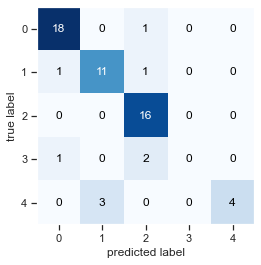

In [389]:
#clf_failure_rf = RandomForestClassifier(criterion = 'entropy', max_depth = 10, n_estimators = 1000)
clf_failure_rf = RandomForestClassifier(criterion = 'gini', max_depth = 10, n_estimators = 100)
clf_failure_rf.fit(X_train, y_train)
y_valid_pred = clf_failure_rf.predict(X_valid)
 

f1_rf_valid = f1_score(y_valid, y_valid_pred,average = 'macro')

print('F1:',f1_rf_valid)

plot_confusion_matrix(confusion_matrix(y_valid, y_valid_pred));

Esta métrica adotada é interessante, pois o modelo acerta bem quase todos os tipos de falhas, mas, o fato de não acertar nenhum da tipo 3, faz com que o modelo tenha uma média de F1 baixa.

#### Modelo tipo de falha - LGBM

In [371]:
model = LGBMClassifier()

parameters = {
    'max_depth': [ 3, 5, 10],
    'n_estimators': [50, 100, 500],
    'learning_rate': [0.01, 0.1, 0.5],
    'importance_type':['gain', 'split']
    }

clf_failure_lgbm = GridSearchCV(model, parameters, verbose=3, scoring='f1_macro', cv= 3)

clf_failure_lgbm.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3] END importance_type=gain, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.562 total time=   0.0s
[CV 2/3] END importance_type=gain, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.672 total time=   0.0s
[CV 3/3] END importance_type=gain, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.706 total time=   0.0s
[CV 1/3] END importance_type=gain, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.597 total time=   0.0s
[CV 2/3] END importance_type=gain, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.672 total time=   0.0s
[CV 3/3] END importance_type=gain, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.742 total time=   0.0s
[CV 1/3] END importance_type=gain, learning_rate=0.01, max_depth=3, n_estimators=500;, score=0.762 total time=   0.3s
[CV 2/3] END importance_type=gain, learning_rate=0.01, max_depth=3, n_estimators=500;, score=0.675 total time=   0.

[CV 2/3] END importance_type=gain, learning_rate=0.5, max_depth=5, n_estimators=500;, score=0.664 total time=   0.1s
[CV 3/3] END importance_type=gain, learning_rate=0.5, max_depth=5, n_estimators=500;, score=0.758 total time=   0.0s
[CV 1/3] END importance_type=gain, learning_rate=0.5, max_depth=10, n_estimators=50;, score=0.832 total time=   0.0s
[CV 2/3] END importance_type=gain, learning_rate=0.5, max_depth=10, n_estimators=50;, score=0.664 total time=   0.0s
[CV 3/3] END importance_type=gain, learning_rate=0.5, max_depth=10, n_estimators=50;, score=0.757 total time=   0.0s
[CV 1/3] END importance_type=gain, learning_rate=0.5, max_depth=10, n_estimators=100;, score=0.857 total time=   0.0s
[CV 2/3] END importance_type=gain, learning_rate=0.5, max_depth=10, n_estimators=100;, score=0.664 total time=   0.0s
[CV 3/3] END importance_type=gain, learning_rate=0.5, max_depth=10, n_estimators=100;, score=0.744 total time=   0.0s
[CV 1/3] END importance_type=gain, learning_rate=0.5, max_dep

[CV 1/3] END importance_type=split, learning_rate=0.5, max_depth=3, n_estimators=500;, score=0.813 total time=   0.1s
[CV 2/3] END importance_type=split, learning_rate=0.5, max_depth=3, n_estimators=500;, score=0.821 total time=   0.1s
[CV 3/3] END importance_type=split, learning_rate=0.5, max_depth=3, n_estimators=500;, score=0.757 total time=   0.1s
[CV 1/3] END importance_type=split, learning_rate=0.5, max_depth=5, n_estimators=50;, score=0.832 total time=   0.0s
[CV 2/3] END importance_type=split, learning_rate=0.5, max_depth=5, n_estimators=50;, score=0.676 total time=   0.0s
[CV 3/3] END importance_type=split, learning_rate=0.5, max_depth=5, n_estimators=50;, score=0.745 total time=   0.0s
[CV 1/3] END importance_type=split, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.846 total time=   0.0s
[CV 2/3] END importance_type=split, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.664 total time=   0.0s
[CV 3/3] END importance_type=split, learning_rate=0.5, max_

GridSearchCV(cv=3, estimator=LGBMClassifier(),
             param_grid={'importance_type': ['gain', 'split'],
                         'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [50, 100, 500]},
             scoring='f1_macro', verbose=3)

In [378]:
clf_failure_lgbm.best_params_

{'importance_type': 'gain',
 'learning_rate': 0.5,
 'max_depth': 3,
 'n_estimators': 50}

0.8945547785547786


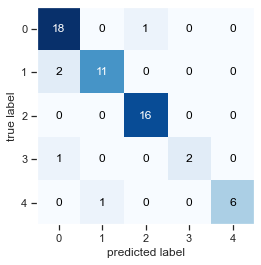

In [26]:
#clf_failure_lgbm = LGBMClassifier(importance_type = 'gain', learning_rate = 0.1, max_depth = 3, 
 #                                 n_estimators = 500)
clf_failure_lgbm = LGBMClassifier(importance_type = 'gain', learning_rate = 0.5, max_depth = 3, 
                                  n_estimators = 50)
clf_failure_lgbm.fit(X_train, y_train)
y_valid_pred = clf_failure_lgbm.predict(X_valid)
 
# model accuracy for X_test 
f1_lgbm = f1_score(y_valid, y_valid_pred,average = 'macro')
print(f1_lgbm)
# creating a confusion matrix
plot_confusion_matrix(confusion_matrix(y_valid, y_valid_pred));

Este modelo performa melhor por ter bons acertos em cada classe, e especificamente a classe 3, onde o modelo anterior do Random Forest não conseguiu aprender

#### Modelo tipo de falha - SVM

In [383]:
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
c = [ 1e-2, 0.1, 1, 10]
gammas = [0.1, 1, 10]
clf = SVC()

parameters = dict(kernel=kernels, C=c, gamma=gammas)
clf_failure_svm = GridSearchCV(clf, parameters, verbose=3, scoring='f1_macro', cv= 3)
clf_failure_svm.fit(X_train, y_train)
clf_failure_svm.best_params_

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END ..C=0.01, gamma=0.1, kernel=linear;, score=0.834 total time=   0.0s
[CV 2/3] END ..C=0.01, gamma=0.1, kernel=linear;, score=0.845 total time=   0.0s
[CV 3/3] END ..C=0.01, gamma=0.1, kernel=linear;, score=0.848 total time=   0.0s
[CV 1/3] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.095 total time=   0.0s
[CV 2/3] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.099 total time=   0.0s
[CV 3/3] END .....C=0.01, gamma=0.1, kernel=rbf;, score=0.099 total time=   0.0s
[CV 1/3] END ....C=0.01, gamma=0.1, kernel=poly;, score=0.766 total time=   0.0s
[CV 2/3] END ....C=0.01, gamma=0.1, kernel=poly;, score=0.910 total time=   0.0s
[CV 3/3] END ....C=0.01, gamma=0.1, kernel=poly;, score=0.818 total time=   0.0s
[CV 1/3] END .C=0.01, gamma=0.1, kernel=sigmoid;, score=0.095 total time=   0.0s
[CV 2/3] END .C=0.01, gamma=0.1, kernel=sigmoid;, score=0.099 total time=   0.0s
[CV 3/3] END .C=0.01, gamma=0.1, kernel=sigmoid

[CV 3/3] END .........C=1, gamma=10, kernel=rbf;, score=0.099 total time=   0.0s
[CV 1/3] END ........C=1, gamma=10, kernel=poly;, score=0.766 total time=   0.0s
[CV 2/3] END ........C=1, gamma=10, kernel=poly;, score=0.910 total time=   0.0s
[CV 3/3] END ........C=1, gamma=10, kernel=poly;, score=0.818 total time=   0.0s
[CV 1/3] END .....C=1, gamma=10, kernel=sigmoid;, score=0.095 total time=   0.0s
[CV 2/3] END .....C=1, gamma=10, kernel=sigmoid;, score=0.099 total time=   0.0s
[CV 3/3] END .....C=1, gamma=10, kernel=sigmoid;, score=0.099 total time=   0.0s
[CV 1/3] END ....C=10, gamma=0.1, kernel=linear;, score=0.861 total time=   0.0s
[CV 2/3] END ....C=10, gamma=0.1, kernel=linear;, score=0.910 total time=   0.0s
[CV 3/3] END ....C=10, gamma=0.1, kernel=linear;, score=0.832 total time=   0.0s
[CV 1/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.125 total time=   0.0s
[CV 2/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.129 total time=   0.0s
[CV 3/3] END .......C=10, ga

{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}

0.8052393857271906


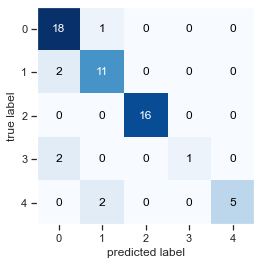

In [27]:
#clf_failure_svm = SVC(gamma = 0.1, kernel = 'linear').fit(X_train, y_train)
clf_failure_svm = SVC(C = 0.1, gamma = 0.1, kernel = 'linear').fit(X_train, y_train)
y_valid_pred = clf_failure_svm.predict(X_valid)
 
f1_svm = f1_score(y_valid, y_valid_pred,average = 'macro')
print(f1_svm)

plot_confusion_matrix(confusion_matrix(y_valid, y_valid_pred));

Performance parecida com o LGBM, mas, teve 2 erros a mais fazendo com que perdesse quais 10 percentuais na métrica. Assim, o modelo LGBM será escolhido para o modelo 2.

In [28]:
# armazenando o modelo como arquivo pickle
pickle.dump(clf_failure_lgbm, open('detect_type_failure.pkl', 'wb'))

### Funções

Funções para criação de um modelo único.

In [29]:
# função para transformação da variável type em dummy

def transform_type(data, column):
    
    data = data.copy()
    
    # instanciando a função que cria as variaveis binarias, com 'drop' removendo a primeira categoria
    enc = OneHotEncoder(handle_unknown='ignore', drop = 'first')

    # fitando e transformando a variável em column    
    type_trans = enc.fit_transform(np.array(data[column]).reshape(-1,1)).toarray()
    
    # cria um dataframe com as variaveis dummies e concatena com o original
    df_type = pd.DataFrame(type_trans, columns = ['Type 0', 'Type 1'])
    data = pd.concat([data,df_type], axis = 1)
    
    return data



In [30]:
# arquivo pickle para a função 
pickle.dump(transform_type, open('function_transform_type.pkl', 'wb'))

In [31]:
# função que detecta falhas utilizando os dois modelos criados

def failure_prediction(data):
    
    data = data.copy()
    
    
    # transforma a variável type com a função criada
    function_transform_type = pickle.load(open('function_transform_type.pkl', 'rb'))
    data = function_transform_type(data, 'type')
    
    
    # atribuir os dados para a predição de falha
    X_failure = data.drop(['udi','product_id', 'type'], axis = 1)
    
    # modelo 1 para detectar as falhas
    detect_failure = pickle.load(open('detect_failure.pkl', 'rb'))
    predicts_failure = detect_failure.predict(X_failure)
    
    # armazenando as predições em uma coluna
    data['predict'] = predicts_failure
    
    # atribuindo as predições 0 a categoria sem falha (No Failure)
    data.loc[data['predict'] == 0, 'predict'] = 'No Failure'
    
    # separando as predições de falhas para o aplicar no modelo 2 de tipo de falha
    X_type_failure = data.loc[data['predict'] == 1]
    
    # modelo 2 para a predição do tipo de falha
    detect_type_failure = pickle.load(open('detect_type_failure.pkl', 'rb'))
    
    predicts_type_failure = detect_type_failure.predict(X_type_failure.drop(['udi','product_id', 
                                                                             'type', 'predict'], axis = 1))
    
    # invertendo a função do Label Encoder para converter os labels do tipo de falha em seus respectivos nomes
    label_failure = pickle.load(open('label_failure.pkl', 'rb'))
                                      
    data.loc[data['predict'] == 1, 'predict'] = label_failure.inverse_transform(predicts_type_failure)
    
    
    return data['predict']

In [32]:
pickle.dump(failure_prediction, open('function_failure_prediction.pkl', 'wb'))

#### Testando a função dos modelos no datafame original

In [33]:
df_original = pd.read_csv('desafio_manutencao_preditiva_treino.csv')
df_original.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.1,308.6,1551,42.8,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,No Failure
2,5,L47184,L,298.2,308.7,1408,40.0,9,No Failure
3,6,M14865,M,298.1,308.6,1425,41.9,11,No Failure
4,7,L47186,L,298.1,308.6,1558,42.4,14,No Failure


In [34]:
X_original = df_original.drop(['failure_type'], axis = 1)
X_original.shape

(6667, 8)

In [35]:
func_predict = pickle.load(open('function_failure_prediction.pkl', 'rb'))
func_predict(X_original)

0       No Failure
1       No Failure
2       No Failure
3       No Failure
4       No Failure
           ...    
6662    No Failure
6663    No Failure
6664    No Failure
6665    No Failure
6666    No Failure
Name: predict, Length: 6667, dtype: object

In [36]:
f1Score = f1_score (df_original['failure_type'], func_predict(X_original), average = 'macro')
f1Score

0.858459731916004

### Base de Teste

Realizando a predição da base de teste e exportando para csv.

In [38]:
df_teste = pd.read_csv('desafio_manutencao_preditiva_teste.csv')
df_teste

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
0,446,L47625,L,297.5,308.6,1793,26.7,70
1,7076,L54255,L,300.7,310.5,1536,47.4,192
2,1191,L48370,L,297.2,308.4,1460,42.1,41
3,2618,L49797,L,299.4,309.1,1670,35.9,68
4,5067,L52246,L,304.1,313.1,1550,30.9,9
...,...,...,...,...,...,...,...,...
3328,5554,L52733,L,302.5,311.9,1306,59.7,172
3329,6961,L54140,L,300.7,311.0,1413,52.0,91
3330,6914,L54093,L,300.8,311.2,1481,38.5,181
3331,5510,L52689,L,302.8,312.2,1509,36.5,52


In [39]:
df_teste.isna().sum()

udi                      0
product_id               0
type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
dtype: int64

In [40]:
predict = func_predict(df_teste)
df_teste = pd.concat([df_teste,predict], axis = 1)
df_teste

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,predict
0,446,L47625,L,297.5,308.6,1793,26.7,70,No Failure
1,7076,L54255,L,300.7,310.5,1536,47.4,192,No Failure
2,1191,L48370,L,297.2,308.4,1460,42.1,41,No Failure
3,2618,L49797,L,299.4,309.1,1670,35.9,68,No Failure
4,5067,L52246,L,304.1,313.1,1550,30.9,9,No Failure
...,...,...,...,...,...,...,...,...,...
3328,5554,L52733,L,302.5,311.9,1306,59.7,172,No Failure
3329,6961,L54140,L,300.7,311.0,1413,52.0,91,No Failure
3330,6914,L54093,L,300.8,311.2,1481,38.5,181,No Failure
3331,5510,L52689,L,302.8,312.2,1509,36.5,52,No Failure


In [42]:
df_answer = pd.DataFrame({'predictedValues':df_teste['predict'] })
df_answer.index.names = ['rowNumber']
df_answer

,predictedValues
rowNumber,
0,No Failure
1,No Failure
2,No Failure
3,No Failure
4,No Failure
...,...
3328,No Failure
3329,No Failure
3330,No Failure


In [43]:
df_answer.to_csv('predicted.csv')

In [48]:
# adicionando as bibliotecas em txt
!pip freeze > requirements.txt